In [1]:
import os
import json
from pathlib import Path
import typing

import numpy as np
import torch
from transformers import OpenAIGPTLMHeadModel, OpenAIGPTConfig
import pandas as pd
import matplotlib.pyplot as plt

from muutils.logger import Logger, TimerContext
from muutils.json_serialize import json_serialize, dataclass_serializer_factory
from muutils.tensor_utils import ATensor, NDArray
from muutils.statcounter import StatCounter
from muutils.misc import shorten_numerical_to_str

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from maze_transformer.generation.latticemaze import LatticeMaze
from maze_transformer.generation.generators import LatticeMazeGenerators
from maze_transformer.training.tokenizer import MazeTokenizer, SPECIAL_TOKENS
from maze_transformer.training.mazedataset import MazeDatasetConfig, MazeDataset
from maze_transformer.evaluation.plot_maze import plot_multi_paths, PathFormat
from maze_transformer.training.dataset import GPTDatasetConfig
from maze_transformer.training.config import TrainConfig
from maze_transformer.training.training import TRAIN_SAVE_FILES
from maze_transformer.evaluation.eval_model import generate_plot_predicted_path, MazePath, load_model_with_configs, LoadedModelConfigs, predict_maze_path
from maze_transformer.evaluation.pathdist import MazeEvalFunction, ArrMazeEvalFunction, MazeEvalFuncs, ArrMazeEvalFuncs



# plot example mazes

In [2]:
# setup consts
def testdata_plot_predicted_path(
		model_path: str = "data/g4-n4K/g4-n4K_tiny-v1_2022-10-05-02-03-44/model.final.pt",
		n_mazes: int = 10,
		n_tokens_pred: int = 8,
		filename: str = "data/g4-n1K-test/maze_tokens.jsonl",
	):
	mazes_tokens: list[list[str]] = list()

	# load model and configs
	loaded_model_and_configs: LoadedModelConfigs = load_model_with_configs(model_path, MazeDatasetConfig)
	data_cfg: MazeDatasetConfig; train_cfg: TrainConfig
	model_cfg: OpenAIGPTConfig; model: OpenAIGPTLMHeadModel
	data_cfg, train_cfg, model_cfg, model = loaded_model_and_configs
	model.config.max_length = model_cfg.n_positions + 1

	# load maze test data
	with open(filename, "r") as f:
		for line in f:
			mazes_tokens.append(line.split())

	mazes_tokens = mazes_tokens[:n_mazes]

	mazes_solved: list[tuple[LatticeMaze, MazePath, MazePath]] = [
		predict_maze_path(
			tokens = tokens,
			data_cfg = data_cfg,
			model = model,
			n_tokens_pred = n_tokens_pred,
		)
		for tokens in mazes_tokens
	]


	# plot
	for maze, path, path_pred in mazes_solved:
		plot_multi_paths(
			maze = maze,
			paths = [
				PathFormat(path, "true", color = "red", quiver_kwargs = {'width': 0.015}),
				PathFormat(path_pred, "predicted", color = "blue", quiver_kwargs = {}),
			],
		)

# testdata_plot_predicted_path()

# run path dist eval

In [3]:
EvalFuncTuple = tuple[typing.Literal["arr", "list"], MazeEvalFunction|ArrMazeEvalFunction]

ALL_PATHDIST_FUNCS: dict[str, EvalFuncTuple] = {
	**{
		name: ("arr", func)
		for name, func in ArrMazeEvalFuncs.__dict__.items()
		if not name.startswith("_")
	},
	**{
		name: ("list", func)
		for name, func in MazeEvalFuncs.__dict__.items()
		if not name.startswith("_")
	},
}

print(ALL_PATHDIST_FUNCS)

{'fraction_connections_adjacent_lattice': ('arr', <staticmethod(<function ArrMazeEvalFuncs.fraction_connections_adjacent_lattice at 0x000002F25DD9EB00>)>), 'fraction_connections_adjacent': ('arr', <staticmethod(<function ArrMazeEvalFuncs.fraction_connections_adjacent at 0x000002F25DD9EB90>)>), 'node_overlap': ('list', <staticmethod(<function MazeEvalFuncs.node_overlap at 0x000002F25DD9E9E0>)>), 'path_len_diff': ('list', <staticmethod(<function MazeEvalFuncs.path_len_diff at 0x000002F25DD9EA70>)>)}


In [4]:


from maze_transformer.evaluation.eval_model import ArrMazePath


def evaluate_model_pathdist_scores(
		model_path: str,
		pathdist_functions: dict[str, EvalFuncTuple]|None = None,
		n_tokens_pred: int = 8,
		test_data: str = "data/g4-n1K-test/maze_tokens.jsonl",
		n_mazes: int = 10,
		verbose: bool = False,
	) -> dict[str, StatCounter]:

	if pathdist_functions is None:
		pathdist_functions = ALL_PATHDIST_FUNCS

	mazes_tokens: list[list[str]] = list()

	# load model and configs
	loaded_model_and_configs: LoadedModelConfigs = load_model_with_configs(model_path, MazeDatasetConfig)
	data_cfg: MazeDatasetConfig; train_cfg: TrainConfig
	model_cfg: OpenAIGPTConfig; model: OpenAIGPTLMHeadModel
	data_cfg, train_cfg, model_cfg, model = loaded_model_and_configs
	model.config.max_length = model_cfg.n_positions + 1

	# load maze test data
	with open(test_data, "r") as f:
		for idx, line in enumerate(f):
			mazes_tokens.append(line.split())
			if idx >= n_mazes:
				break

	# predict paths
	mazes_solved: list[tuple[LatticeMaze, MazePath, MazePath]] = list()
	for tokens in mazes_tokens:
		maze, p_true, p_pred = predict_maze_path(
			tokens = tokens,
			data_cfg = data_cfg,
			model = model,
			n_tokens_pred = n_tokens_pred,
			verbose = verbose,
		)

		mazes_solved.append((maze, p_true, p_pred))

		if verbose:
			print(f"{p_true = }")
			print(f"{p_pred = }")

	# convert paths
	mazes_solved_arrpath: list[tuple[LatticeMaze, ArrMazePath, ArrMazePath]] = [
		(maze, np.array(p_true), np.array(p_pred))
		for maze, p_true, p_pred in mazes_solved
	]


	# evaluate
	pathdist_scores: dict[str, StatCounter] = dict()
	for name, (pathdist_type, pathdist_func) in pathdist_functions.items():
		if pathdist_type == "list":
			pathdist_scores[name] = StatCounter(
				pathdist_func(maze, p_true, p_pred)
				for maze, p_true, p_pred in mazes_solved
			)
		elif pathdist_type == "arr":
			pathdist_scores[name] = StatCounter(
				pathdist_func(maze, p_true, p_pred)
				for maze, p_true, p_pred in mazes_solved_arrpath
			)
		else:
			raise ValueError(f"Invalid pathdist_type: {pathdist_type}")

	return pathdist_scores

# evaluate_model_pathdist_scores("data/g4-n4K/g4-n4K_tiny-v1_2022-10-05-02-03-44/model.final.pt")

In [5]:
def evaluate_pathdist_scores_checkpoints(
		path_base: str,
		checkpoint_idxs: list[int]|None = None,
		pathdist_functions: dict[str, EvalFuncTuple]|None = None,
		n_tokens_pred: int = 8,
		test_data: str = "data/g4-n1K-test/maze_tokens.jsonl",
		n_mazes: int = 10,
		verbose: bool = False,
	) -> dict[str, dict[int, StatCounter]]:

	model_checkpoints: list[tuple[int,str]]

	if checkpoint_idxs is not None:
		model_checkpoints = list()
		for idx in checkpoint_idxs:
			mdl_path: Path = Path(path_base) / f"model.iter_{idx}.pt"
			if not mdl_path.exists():
				raise ValueError(f"Checkpoint file {mdl_path} does not exist")
			model_checkpoints.append((idx, str(mdl_path)))
	else:
		model_checkpoints = [
			(int(mdl_path.stem.split("_")[-1].split(".")[0]), str(mdl_path))
			for mdl_path in Path(path_base).glob("model.iter_*.pt")
		]
	
	print(f"Found {len(model_checkpoints)} checkpoints:\n\t{model_checkpoints = }")

	pathdist_scores_idx: dict[int, dict[str, StatCounter]] = dict()

	for idx, mdl_path in model_checkpoints:
		print(f"# Evaluating checkpoint {idx} at {mdl_path}")
		pathdist_scores_idx[idx] = evaluate_model_pathdist_scores(
			model_path = mdl_path,
			pathdist_functions = pathdist_functions,
			n_tokens_pred = n_tokens_pred,
			test_data = test_data,
			n_mazes = n_mazes,
			verbose = verbose,
		)

	return {
		name: {
			idx: scores[name]
			for idx, scores in pathdist_scores_idx.items()
		}
		for name in pathdist_scores_idx[0]
	}
		

In [6]:
def plot_pathdist_scores(
		data: dict[str, dict[int, StatCounter]],
		colors: dict[str, str]|None = None,
		percentile_bounds: tuple[float, float] = (0.25, 0.75),
	):

	if colors is None:
		colors = {
			func_name: f"C{i}"
			for i, func_name in enumerate(data.keys())
		}

	plt.figure(figsize=(10, 6))
	
	
	for name, scores_idxed in data.items():
		x = list(scores_idxed.keys())
		y = [
			scores_idxed[idx].median()
			for idx in x
		]
		plt.plot(x, y, label=name, color=colors[name])
		# plot shaded error bars
		y_ub = [
			scores_idxed[idx].percentile(percentile_bounds[1])
			for idx in x
		]
		y_lb = [
			scores_idxed[idx].percentile(percentile_bounds[0])
			for idx in x
		]
		plt.fill_between(
			x, y_lb, y_ub,
	    	alpha=0.5, 
			edgecolor=colors[name], facecolor=colors[name],
		)

	
	plt.legend()
	plt.ylabel("Path score")
	plt.xlabel("iteration")
	plt.show()

In [7]:
data = evaluate_pathdist_scores_checkpoints(
	path_base = "data/g4-n4K/g4-n4K_tiny-v1_2022-10-05-02-03-44/checkpoints/",
	checkpoint_idxs = list(range(0, 9829, 156*4)),
	test_data = "data/g4-n1K-test/maze_tokens.jsonl",
	n_mazes = 16,
	# verbose = True,
)

Found 16 checkpoints:
	model_checkpoints = [(0, 'data\\g4-n4K\\g4-n4K_tiny-v1_2022-10-05-02-03-44\\checkpoints\\model.iter_0.pt'), (624, 'data\\g4-n4K\\g4-n4K_tiny-v1_2022-10-05-02-03-44\\checkpoints\\model.iter_624.pt'), (1248, 'data\\g4-n4K\\g4-n4K_tiny-v1_2022-10-05-02-03-44\\checkpoints\\model.iter_1248.pt'), (1872, 'data\\g4-n4K\\g4-n4K_tiny-v1_2022-10-05-02-03-44\\checkpoints\\model.iter_1872.pt'), (2496, 'data\\g4-n4K\\g4-n4K_tiny-v1_2022-10-05-02-03-44\\checkpoints\\model.iter_2496.pt'), (3120, 'data\\g4-n4K\\g4-n4K_tiny-v1_2022-10-05-02-03-44\\checkpoints\\model.iter_3120.pt'), (3744, 'data\\g4-n4K\\g4-n4K_tiny-v1_2022-10-05-02-03-44\\checkpoints\\model.iter_3744.pt'), (4368, 'data\\g4-n4K\\g4-n4K_tiny-v1_2022-10-05-02-03-44\\checkpoints\\model.iter_4368.pt'), (4992, 'data\\g4-n4K\\g4-n4K_tiny-v1_2022-10-05-02-03-44\\checkpoints\\model.iter_4992.pt'), (5616, 'data\\g4-n4K\\g4-n4K_tiny-v1_2022-10-05-02-03-44\\checkpoints\\model.iter_5616.pt'), (6240, 'data\\g4-n4K\\g4-n4K_tiny-

loaded model with 28M parameters
# Evaluating checkpoint 624 at data\g4-n4K\g4-n4K_tiny-v1_2022-10-05-02-03-44\checkpoints\model.iter_624.pt


loaded model with 28M parameters
# Evaluating checkpoint 1248 at data\g4-n4K\g4-n4K_tiny-v1_2022-10-05-02-03-44\checkpoints\model.iter_1248.pt


loaded model with 28M parameters
# Evaluating checkpoint 1872 at data\g4-n4K\g4-n4K_tiny-v1_2022-10-05-02-03-44\checkpoints\model.iter_1872.pt


loaded model with 28M parameters
# Evaluating checkpoint 2496 at data\g4-n4K\g4-n4K_tiny-v1_2022-10-05-02-03-44\checkpoints\model.iter_2496.pt


loaded model with 28M parameters
# Evaluating checkpoint 3120 at data\g4-n4K\g4-n4K_tiny-v1_2022-10-05-02-03-44\checkpoints\model.iter_3120.pt


loaded model with 28M parameters
# Evaluating checkpoint 3744 at data\g4-n4K\g4-n4K_tiny-v1_2022-10-05-02-03-44\checkpoints\model.iter_3744.pt


loaded model with 28M parameters
# Evaluating checkpoint 4368 at data\g4-n4K\g4-n4K_tiny-v1_2022-10-05-02-03-44\checkpoints\model.iter_4368.pt


loaded model with 28M parameters
# Evaluating checkpoint 4992 at data\g4-n4K\g4-n4K_tiny-v1_2022-10-05-02-03-44\checkpoints\model.iter_4992.pt


loaded model with 28M parameters
# Evaluating checkpoint 5616 at data\g4-n4K\g4-n4K_tiny-v1_2022-10-05-02-03-44\checkpoints\model.iter_5616.pt


loaded model with 28M parameters
# Evaluating checkpoint 6240 at data\g4-n4K\g4-n4K_tiny-v1_2022-10-05-02-03-44\checkpoints\model.iter_6240.pt


loaded model with 28M parameters
# Evaluating checkpoint 6864 at data\g4-n4K\g4-n4K_tiny-v1_2022-10-05-02-03-44\checkpoints\model.iter_6864.pt


loaded model with 28M parameters
# Evaluating checkpoint 7488 at data\g4-n4K\g4-n4K_tiny-v1_2022-10-05-02-03-44\checkpoints\model.iter_7488.pt


loaded model with 28M parameters
# Evaluating checkpoint 8112 at data\g4-n4K\g4-n4K_tiny-v1_2022-10-05-02-03-44\checkpoints\model.iter_8112.pt


loaded model with 28M parameters
# Evaluating checkpoint 8736 at data\g4-n4K\g4-n4K_tiny-v1_2022-10-05-02-03-44\checkpoints\model.iter_8736.pt


loaded model with 28M parameters
# Evaluating checkpoint 9360 at data\g4-n4K\g4-n4K_tiny-v1_2022-10-05-02-03-44\checkpoints\model.iter_9360.pt


loaded model with 28M parameters


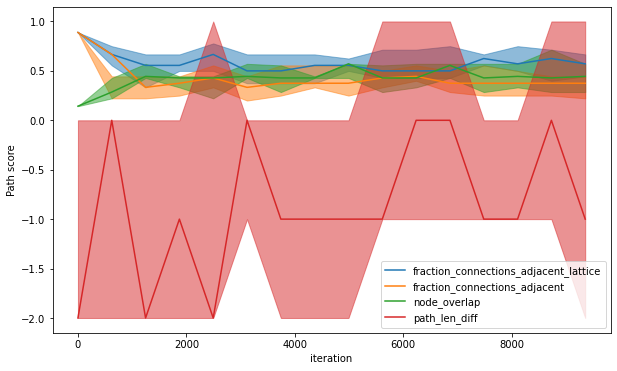

In [8]:
plot_pathdist_scores(data)

In [9]:


# generate_plot_predicted_path("data/g4-n4K/g4-n4K_tiny-v1_2022-09-10-02-02-12/checkpoints/model.iter_3120.pt")
